In [1]:
# 初期状態をどうするのか
# time step
# 具体的にどのようなシミュレーションをするのか
# 参考になりそうなurl
# https://nbviewer.jupyter.org/github/jrjohansson/qutip-lectures/blob/master/Lecture-14-Kerr-nonlinearities.ipynb

In [28]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import copy
import os
import qulacs
from qulacs import QuantumState, QuantumCircuit
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs.gate import DenseMatrix, SparseMatrix, DiagonalMatrix
from qutip import *
from scipy.linalg import expm, sinm, cosm
from scipy.sparse import csc_matrix

#import cupy as cp
#from qulacs import QuantumAnnealing
#from qulacs import QuantumDynamicsDiagonal
from qulacs import QuantumStateGpu, QuantumAnnealingGpu, QuantumDynamicsDiagonalGpu
#import strawberryfields as sf
#from strawberryfields import ops


$$
H=\Delta a^\dagger a + \frac{K}{2} a^{\dagger 2} a^2 - \frac{p}{2}(a^2+ a^{\dagger 2} )
$$

In [2]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))

    if isket(rho):
        rho = ket2dm(rho)
    
    xvec = np.linspace(-3.5,3.5,200)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec, xvec, W, 100, norm=matplotlib.colors.Normalize(-wlim,wlim), cmap=matplotlib.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)

    return fig, ax

$$
H=\Delta a^\dagger a + \frac{K}{2} a^{\dagger 2} a^2 - \frac{p}{2}(a^2+ a^{\dagger 2} ) \\
e^{-iHt} = \exp(-i \Delta a^\dagger a t) \exp(-i \frac{K}{2} \hat{n}^2 t) \exp(i \frac{K}{2} \hat{n} t) \exp(i \frac{p}{2}(a^2+a^{\dagger 2})t)
$$

In [3]:
# qutip
n_bosons = 1
cut_off = 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 3 # 4 if delta = 1, 3 if delta = -1

K = 1
delta = -1 # 1, -1
tlist = np.linspace(0, 5, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
# Jising = np.random.randn(n_bosons, n_bosons)
Jising = np.zeros((n_bosons, n_bosons))
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", dim: ", cut_off_dim**n_bosons)

start = time.perf_counter()
state = basis(cut_off_dim, 0)
H0 = delta * n + 0.5 * K * (n*n-n) 
H1 = a * a + a.dag() * a.dag()
for t, p in zip (tlist, plist):
    H = expm(-1.j*time_step*np.array(H0-0.5*p*H1))
    H = qutip.Qobj(H)
    constant_form = qutip.QobjEvo([H])
    #constant_form.compile()
    state = (constant_form*state)
end = time.perf_counter()
print(end-start, " sec")

cut off dim:  16 , n_boson:  1 , dim:  16
5.346114499999999  sec


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

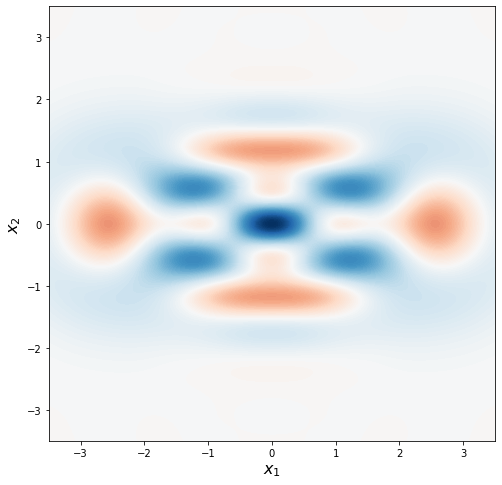

In [4]:
# delta = 1
plot_wigner(state(0))

In [5]:
# qutip by master equation
p_step = p_max/max_step
def f1_t(t, args):
    H = H0-0.5*p_step*t*H1
    return qutip.Qobj(H)

start = time.perf_counter()
state = basis(cut_off_dim, 0)
values = 0.5*plist
array_form = qutip.QobjEvo([H0, [H1, values]], tlist=tlist)
s_sim = time.perf_counter()
output = mesolve(array_form, state, tlist, [], [])
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", end-s_sim, "sec")

0.571158999999998 sec
simulaton time:  0.5657067999999974 sec


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

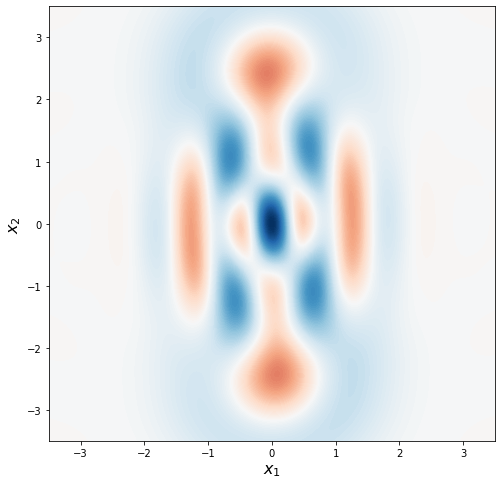

In [6]:
# delta = 1
plot_wigner(output.states[-1])

In [7]:
# qulacs
opt = QuantumCircuitOptimizer()
max_block_size = 4
state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
diag_mat1 = np.diagonal( expm(-1.j*delta*np.array(n)*time_step) )
diag_mat2 = np.diagonal( expm(-1.j*0.5*K*np.array(n*n)*time_step) )
diag_mat3 = np.diagonal( expm(1.j*0.5*K*np.array(n)*time_step) )
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step)
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4 )
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    #gate1.update_quantum_state(state)
    #gate2.update_quantum_state(state)
    #gate3.update_quantum_state(state)
    #gate4.update_quantum_state(state)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            # gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time += e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
print(np.sum(state_prob))
index = np.argmax(state_prob)
print(index, state_prob[index])

1.7014713000000015 sec
simulaton time:  0.023199399999995762 sec
(0.9999999999995353+0j)
0 (0.3652581117512656+0j)


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

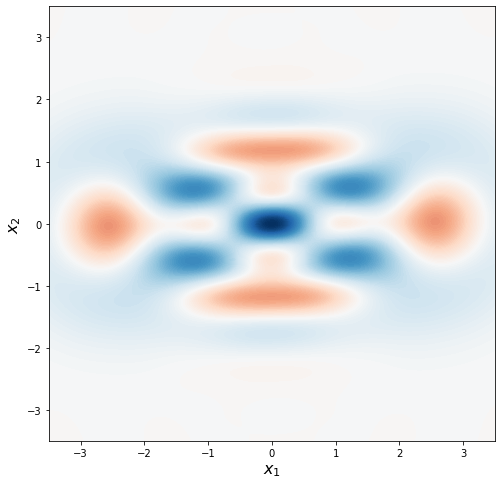

In [8]:
# delta = 1
plot_wigner(Qobj(state_vec))

In [9]:
# 2 mode

In [10]:
n_bosons = 2
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", dim: ", cut_off_dim**n_bosons)

state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  2 , dim:  64
3.0421361000000005 sec
simulaton time:  0.15362340000000074 sec
(1.0000000000001623+0j)


In [11]:
# two-mode wigner function
def disp(alpha1, m, n):
    tmp_p = 0
    fact_m = math.factorial(m)
    fact_n = math.factorial(n)
    for k in range(min(n,m)+1):
        tmp_p += alpha1**(m-k) * (-1*np.conj(alpha1))**(n-k) / math.factorial(k) / math.factorial(m-k) / math.factorial(n-k)
    tmp_p *= np.exp(-0.5*np.abs(alpha1)**2)*math.sqrt(fact_m*fact_n)
    return tmp_p

def twomode_wigner_x(rho, xvec1, xvec2):
    X1, X2 = np.meshgrid(xvec1, xvec2)
    A1 = (X1+0.0j)/math.sqrt(2) # alpha1
    A2 = (X2+0.0j)/math.sqrt(2) # alpha2
    W = 0
    LEN = rho.shape[0]
    for i in range(LEN):
        dim1_i = i % cut_off_dim
        dim2_i = i >> cut_off
        tmp = 0
        for j in range(LEN):
            dim1_j = j % cut_off_dim
            dim2_j = j >> cut_off
            tmp2 = 0
            for k in range(LEN):
                dim1_k = k % cut_off_dim
                dim2_k = k >> cut_off
                tmp2 += disp(-1*A1, dim1_i, dim1_k) * disp(-1*A2, dim2_i, dim2_k) * rho[k][j]
            tmp += tmp2 * disp(A1, dim1_j, dim1_i) * disp(A2, dim2_j, dim2_i) # ij ji
        W += (-1)**dim1_i *(-1)**dim2_i * tmp
    return 4/(math.pi**2)*np.real(W)

def twomode_wigner_y(rho, yvec1, yvec2):
    Y1, Y2 = np.meshgrid(yvec1, yvec2)
    A1 = 1.0j*Y1/math.sqrt(2) # alpha1
    A2 = 1.0j*Y2/math.sqrt(2) # alpha2
    W = 0
    LEN = rho.shape[0]
    for i in range(LEN):
        dim1_i = i % cut_off_dim
        dim2_i = i >> cut_off
        tmp = 0
        for j in range(LEN):
            dim1_j = j % cut_off_dim
            dim2_j = j >> cut_off
            tmp2 = 0
            for k in range(LEN):
                dim1_k = k % cut_off_dim
                dim2_k = k >> cut_off
                tmp2 += disp(-1*A1, dim1_i, dim1_k) * disp(-1*A2, dim2_i, dim2_k) * rho[k][j]
            tmp += tmp2 * disp(A1, dim1_j, dim1_i) * disp(A2, dim2_j, dim2_i) # ij ji
        W += (-1)**dim1_i *(-1)**dim2_i * tmp
    return 4/(math.pi**2)*np.real(W)

def plot_twomode_wigner_y(rho):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    rho = ket2dm(rho)
    rho = np.array(rho)
    xvec = np.linspace(-3.5,3.5,200)
    Wlist = twomode_wigner_y(rho, xvec, xvec)
    wlim = abs(Wlist).max()
    ax.contourf(xvec, xvec, Wlist, 100, norm=matplotlib.colors.Normalize(-wlim,wlim), cmap=matplotlib.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'$y_1$', fontsize=16)
    ax.set_ylabel(r'$y_2$', fontsize=16)
    return fig, ax

def plot_twomode_wigner_x(rho):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    rho = ket2dm(rho)
    rho = np.array(rho)
    xvec = np.linspace(-3.5,3.5,200)
    Wlist = twomode_wigner_x(rho, xvec, xvec)
    wlim = abs(Wlist).max()
    ax.contourf(xvec, xvec, Wlist, 100, norm=matplotlib.colors.Normalize(-wlim,wlim), cmap=matplotlib.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)
    return fig, ax


In [12]:
from joblib import Parallel, delayed

def twomode_wigner_tmp(rho, i, A1, A2, LEN):
    dim1_i = i % cut_off_dim
    dim2_i = i >> cut_off
    tmp = 0
    W=0
    for j in range(LEN):
        dim1_j = j % cut_off_dim
        dim2_j = j >> cut_off
        tmp2 = 0
        for k in range(LEN):
            dim1_k = k % cut_off_dim
            dim2_k = k >> cut_off
            tmp2 += disp(-1*A1, dim1_i, dim1_k) * disp(-1*A2, dim2_i, dim2_k) * rho[k][j]
        tmp += tmp2 * disp(A1, dim1_j, dim1_i) * disp(A2, dim2_j, dim2_i) # ij ji
    W += (-1)**dim1_i *(-1)**dim2_i * tmp
    return W

def twomode_wigner_x_parallel(rho, xvec1, xvec2):
    X1, X2 = np.meshgrid(xvec1, xvec2)
    A1 = (X1+0.0j)/math.sqrt(2) # alpha1
    A2 = (X2+0.0j)/math.sqrt(2) # alpha2
    LEN = rho.shape[0]
    result = Parallel(n_jobs=-1)([delayed(twomode_wigner_tmp)(rho, i, A1, A2, LEN) for i in range(LEN)])
    W = sum(result)
    return 4/(math.pi**2)*np.real(W)

def plot_twomode_wigner_x(rho):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    rho = ket2dm(rho)
    rho = np.array(rho)
    #xvec = np.linspace(-3.5,3.5,200)
    xvec = np.linspace(-3.5,3.5,100)
    Wlist = twomode_wigner_x_parallel(rho, xvec, xvec)
    wlim = abs(Wlist).max()
    ax.contourf(xvec, xvec, Wlist, 100, norm=matplotlib.colors.Normalize(-wlim,wlim), cmap=matplotlib.cm.get_cmap('RdBu'))
    # ax.contourf(xvec, xvec, Wlist, 100, norm=matplotlib.colors.Normalize(-1, 1), cmap=matplotlib.cm.get_cmap('RdBu'))    
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)
    return fig, ax


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

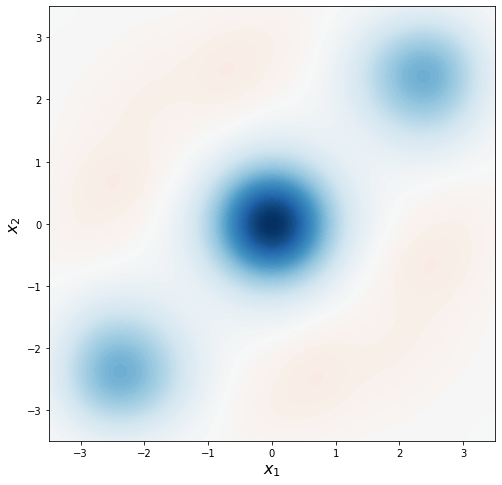

In [13]:
plot_twomode_wigner_x( Qobj(state_vec) )

In [14]:
def twomode_wigner_y_parallel(rho, yvec1, yvec2):
    Y1, Y2 = np.meshgrid(yvec1, yvec2)
    A1 = 1.0j*Y1/math.sqrt(2) # alpha1
    A2 = 1.0j*Y2/math.sqrt(2) # alpha2
    LEN = rho.shape[0]
    result = Parallel(n_jobs=-1)([delayed(twomode_wigner_tmp)(rho, i, A1, A2, LEN) for i in range(LEN)])
    W = sum(result)
    return 4/(math.pi**2)*np.real(W)

def plot_twomode_wigner_y(rho):
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    rho = ket2dm(rho)
    rho = np.array(rho)
    xvec = np.linspace(-3.5,3.5,100)
    Wlist = twomode_wigner_y_parallel(rho, xvec, xvec)
    wlim = abs(Wlist).max()
    ax.contourf(xvec, xvec, Wlist, 100, norm=matplotlib.colors.Normalize(-wlim,wlim), cmap=matplotlib.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'$y_1$', fontsize=16)
    ax.set_ylabel(r'$y_2$', fontsize=16)
    return fig, ax

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$y_1$', ylabel='$y_2$'>)

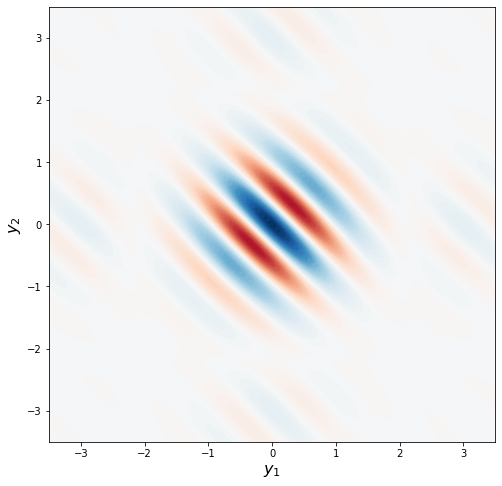

In [15]:
plot_twomode_wigner_y( Qobj(state_vec) )

In [16]:
# qutip by master equation
eig = qutip.qeye(cut_off_dim)
H0 = delta * n + 0.5 * K * (n*n-n)
H0 = tensor(H0, eig)+tensor(eig, H0)

H1 = a * a + a.dag() * a.dag()
H1 = tensor(H1, eig)+tensor(eig, H1)

#H2 = a.dag() * a + a * a.dag()
H2 = 0.5*xi*Jising[0][1]*( tensor(a.dag(), a)+tensor(a, a.dag()) )
H2 += 0.5*xi*Jising[1][0]*( tensor(a, a.dag())+tensor(a.dag(), a) )

p_step = p_max/max_step
start = time.perf_counter()
state = basis(cut_off_dim**n_bosons, 0)
values = 0.5*plist
array_form = qutip.QobjEvo([H0, [H1, values], H2], tlist=tlist)
output = mesolve(array_form, state, tlist, [], [])
end = time.perf_counter()
print(end-start, "sec")

0.948902199999992 sec


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

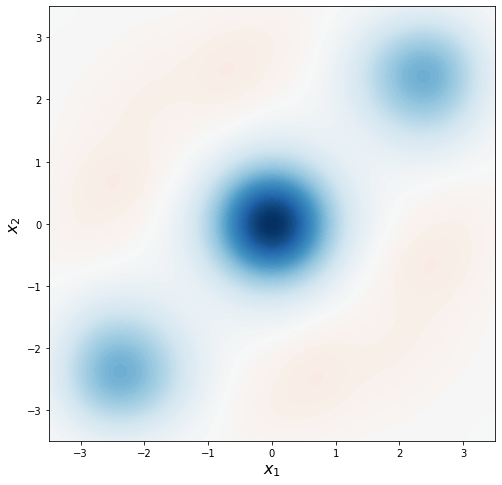

In [17]:
plot_twomode_wigner_x( Qobj(state_vec) )

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$y_1$', ylabel='$y_2$'>)

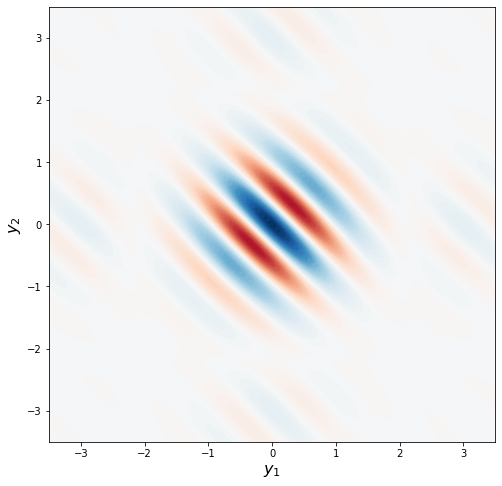

In [18]:
plot_twomode_wigner_y( Qobj(state_vec) )

In [19]:
# qutip 
eig = qutip.qeye(cut_off_dim)
H0 = delta * n + 0.5 * K * (n*n-n)
H0 = tensor(H0, eig)+tensor(eig, H0)

H1 = a * a + a.dag() * a.dag()
H1 = tensor(H1, eig)+tensor(eig, H1)

#H2 = a.dag() * a + a * a.dag()
H2 = 0.5*xi*Jising[0][1]*( tensor(a.dag(), a)+tensor(a, a.dag()) )
H2 += 0.5*xi*Jising[1][0]*( tensor(a, a.dag())+tensor(a.dag(), a) )

start = time.perf_counter()
state = basis(cut_off_dim**n_bosons, 0)
for t, p in zip (tlist, plist):
    H = expm(-1.j*time_step*np.array(H0-0.5*p*H1-H2))
    H = qutip.Qobj(H)
    constant_form = qutip.QobjEvo([H])
    #constant_form.compile()
    state = (constant_form*state)
end = time.perf_counter()
print(end-start, " sec")

15.448752400000046  sec


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$x_1$', ylabel='$x_2$'>)

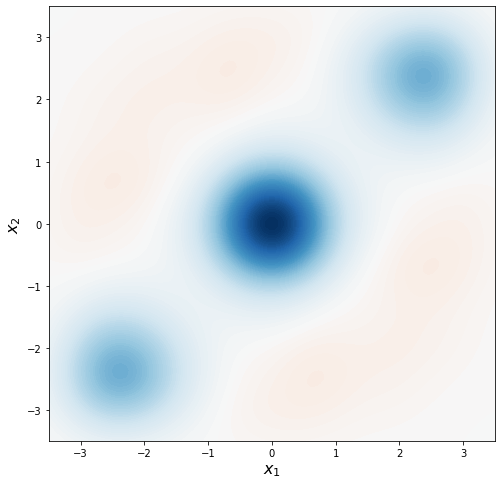

In [20]:
plot_twomode_wigner_x( state(0) )

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:xlabel='$y_1$', ylabel='$y_2$'>)

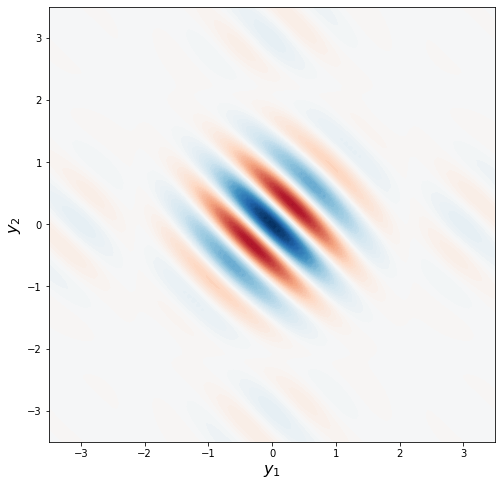

In [21]:
plot_twomode_wigner_y( state(0) )

In [22]:
# simulation time
# single mode
# qulacs: 1.7491651000000008 sec (0.030160600000000315 sec) => 1.6552463 sec (0.020591 sec)
# qutip: 5.2889143999999995  sec
# qutip(master equation): 0.5691927999999997 sec

# two-mode
# qulacs: 18.5205354 sec (0.20411929999999856 sec) => 2.8775202 sec (0.15146559 sec)
# qutip: 13.880946699999981  sec
# qutip(master equation): 0.9498378999999915 sec


In [43]:
n_bosons = 2
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  2 , n_qubit:  6 , dim:  64
6.229521499997645 sec
simulaton time:  0.156498799999099 sec
(1.0000000000001623+0j)


In [44]:
n_bosons = 3
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  3 , n_qubit:  9 , dim:  512
25.390431399999216 sec
simulaton time:  2.3929751999967266 sec
(0.9999999999987572+0j)


In [45]:
n_bosons = 4
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  4 , n_qubit:  12 , dim:  4096
96.06503709999743 sec
simulaton time:  36.29829769999924 sec
(0.9999999999988218+0j)


In [47]:
n_bosons = 5
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  5 , n_qubit:  15 , dim:  32768
620.8011148999976 sec
simulaton time:  511.67151379999996 sec
(0.9999999999977887+0j)


In [48]:
n_bosons = 6
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  6 , n_qubit:  18 , dim:  262144
6722.9945517000015 sec
simulaton time:  6481.4000887 sec
(0.9999999999993641+0j)


In [ ]:
n_bosons = 7
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumState(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = state.get_vector()
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  7 , n_qubit:  21 , dim:  2097152


In [ ]:
# GPU

In [37]:
n_bosons = 2
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  2 , n_qubit:  6 , dim:  64
10.80833359999815 sec
simulaton time:  5.889823299999989 sec
(1.0000000000011673+0j)


In [38]:
n_bosons = 3
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  3 , n_qubit:  9 , dim:  512
46.08507989999998 sec
simulaton time:  14.748829399999522 sec
(0.9999999999982323+0j)


In [39]:
n_bosons = 4
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  4 , n_qubit:  12 , dim:  4096
106.02376689999801 sec
simulaton time:  32.27748910000082 sec
(0.9999999999963365+0j)


In [40]:
n_bosons = 5
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  5 , n_qubit:  15 , dim:  32768
198.40505219999977 sec
simulaton time:  51.497781800000666 sec
(0.9999999999934429+0j)


In [31]:
n_bosons = 6
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  6 , dim:  262144
507.1196854 sec
simulaton time:  287.2890569000001 sec
(0.9999999999898721+0j)


In [32]:
n_bosons = 7
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  7 , n_qubit:  21 , dim:  2097152
2107.1070027000005 sec
simulaton time:  1739.7250926000006 sec
(0.999999999985213+0j)


In [33]:
n_bosons = 8
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  8 , n_qubit:  24 , dim:  16777216
16865.0838142 sec
simulaton time:  16213.2733382 sec
(0.9999999999801996+0j)


In [34]:
n_bosons = 9
cut_off = 3 # 4
cut_off_dim = 2**cut_off
max_step = 10000
t_max = 100
time_step = t_max / max_step
p_max = 4

K = 1
delta = 1
tlist = np.linspace(0, t_max, max_step) # time
plist = np.linspace(0, p_max, max_step) # 0 to 4

# annihilation operator
a = destroy(cut_off_dim) # 2**cut_off x 2**cut_off
# number operator
n = num(cut_off_dim) # 2**cut_off x 2**cut_off

alpha = 0.1+0.1j
xi = 0.5
Jising = np.random.randn(n_bosons, n_bosons)
for i in range(n_bosons):
    Jising[i][i]=0
    for j in range(i):
        Jising[i][j]=Jising[j][i]=1
print("cut off dim: ", cut_off_dim, ", n_boson: ", n_bosons, ", n_qubit: ", n_bosons*cut_off, ", dim: ", cut_off_dim**n_bosons)

state = QuantumStateGpu(cut_off*n_bosons)

sim_time = 0
start = time.perf_counter()
# dense_mat1 = expm(-1.j*delta*np.array(n)*time_step)
# dense_mat2 = expm(-1.j*0.5*K*np.array(n*n)*time_step)
# dense_mat3 = expm(1.j*0.5*K*np.array(n)*time_step)
diag_mat1 = np.diagonal(expm(-1.j*delta*np.array(n)*time_step))
diag_mat2 = np.diagonal(expm(-1.j*0.5*K*np.array(n*n)*time_step))
diag_mat3 = np.diagonal(expm(1.j*0.5*K*np.array(n)*time_step))
tmp_a = np.array(a*a + a.dag()*a.dag())
tmp = np.kron(np.array(a), np.array(a.dag()))+np.kron(np.array(a.dag()), np.array(a))
tmp_expm = [ expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) if i!=j else 0 for i in range(n_bosons) for j in range(n_bosons)]
QC = QuantumCircuit(cut_off*n_bosons)
for t, p in zip(tlist, plist):
    tmp_expm4 = expm(1.j*0.5*p*tmp_a*time_step )
    for i in range(n_bosons):
        gate1 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat1)
        #H = 0.5 * K * a.dag() * a.dag() * a * a
        gate2 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat2)
        gate3 = DiagonalMatrix([j+cut_off*i for j in range(cut_off)], diag_mat3)
        #H = - 0.5 * p * ( a * a + a.dag() * a.dag())
        gate4 = DenseMatrix([j+cut_off*i for j in range(cut_off)], tmp_expm4)        
        #gate1.update_quantum_state(state)
        #gate2.update_quantum_state(state)
        #gate3.update_quantum_state(state)
        #gate4.update_quantum_state(state)
        QC.add_gate(gate1)
        QC.add_gate(gate2)
        QC.add_gate(gate3)
        QC.add_gate(gate4)
    for i in range(n_bosons):
        for j in range(n_bosons):
            if i==j:
                continue
            # gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], expm(1.j*0.5*xi*Jising[i][j]*tmp*time_step) )
            gate = DenseMatrix([k+i*cut_off for k in range(cut_off)]+[k+j*cut_off for k in range(cut_off)], tmp_expm[i*n_bosons+j])
            #gate.update_quantum_state(state)
            QC.add_gate(gate)
#opt.optimize(QC, max_block_size)
s_sim_time = time.perf_counter()
QC.update_quantum_state(state)
e_sim_time = time.perf_counter()
sim_time = e_sim_time - s_sim_time
end = time.perf_counter()
print(end-start, "sec")
print("simulaton time: ", sim_time, "sec")

state_vec = np.array(state.get_vector())
state_prob = state_vec *state_vec.conj()
#print(pd.DataFrame(state_prob))
print(np.sum(state_prob))

cut off dim:  8 , n_boson:  9 , n_qubit:  27 , dim:  134217728


KeyboardInterrupt: 